In [1]:
!pip install -qU  llama-hub 'google-generativeai>=0.3.0' "google-ai-generativelanguage>=0.4,<=1.0" openai tiktoken "llama-index" matplotlib chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!mkdir -p 'data2/paul_graham/'
!wget 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt' -O 'data2/paul_graham/paul_graham_essay.txt'

--2024-01-21 05:53:51--  https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75042 (73K) [text/plain]
Saving to: ‘data2/paul_graham/paul_graham_essay.txt’

data2/paul_graham/p 100%[===================>]  73.28K  --.-KB/s    in 0.01s   

2024-01-21 05:53:51 (5.54 MB/s) - ‘data2/paul_graham/paul_graham_essay.txt’ saved [75042/75042]



In [3]:
import os
import openai
import logging
import sys
from IPython.display import Markdown, display

from pathlib import Path
import random
from typing import Optional

from llama_index.llms import OpenAI
# from llama_index.callbacks import CallbackManager, WandbCallbackHandler
from llama_index import load_index_from_storage

import pandas as pd
# from llama_index.query_engine import PandasQueryEngine

from pprint import pprint
from llama_index import (
    VectorStoreIndex,
    SimpleKeywordTableIndex,
    SimpleDirectoryReader,
    StorageContext,
    ServiceContext,
)


#Setup  OPEN API Key
os.environ["OPENAI_API_KEY"] = ""

# openai_key = "" #<--- Your API KEY
# openai.api_key = openai_key

GOOGLE_API_KEY = ""  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [5]:
import requests


def get_wikipedia_images(title):
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "imageinfo",
            "iiprop": "url|dimensions|mime",
            "generator": "images",
            "gimlimit": "50",
        },
    ).json()
    image_urls = []
    for page in response["query"]["pages"].values():
        if page["imageinfo"][0]["url"].endswith(".jpg") or page["imageinfo"][
            0
        ]["url"].endswith(".png"):
            image_urls.append(page["imageinfo"][0]["url"])
    return image_urls

In [6]:
from pathlib import Path
import urllib.request

image_uuid = 0
MAX_IMAGES_PER_WIKI = 20

wiki_titles = {
    "Tesla Model X",
    "Pablo Picasso",
    "Rivian",
    "The Lord of the Rings",
    "The Matrix",
    "The Simpsons",
}

data_path = Path("mixed_wiki")
if not data_path.exists():
    Path.mkdir(data_path)

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "format": "json",
            "titles": title,
            "prop": "extracts",
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

    images_per_wiki = 0
    try:
        # page_py = wikipedia.page(title)
        list_img_urls = get_wikipedia_images(title)
        # print(list_img_urls)

        for url in list_img_urls:
            if url.endswith(".jpg") or url.endswith(".png"):
                image_uuid += 1
                # image_file_name = title + "_" + url.split("/")[-1]

                urllib.request.urlretrieve(
                    url, data_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                # Limit the number of images downloaded per wiki page to 15
                if images_per_wiki > MAX_IMAGES_PER_WIKI:
                    break
    except:
        print(str(Exception("No images found for Wikipedia page: ")) + title)
        continue

No images found for Wikipedia page: Tesla Model X
No images found for Wikipedia page: The Simpsons
No images found for Wikipedia page: The Lord of the Rings
No images found for Wikipedia page: Pablo Picasso
No images found for Wikipedia page: Rivian


In [8]:
!pip install open-clip-torch -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.2 MB/s eta 0:00:00


In [9]:
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction

# set defalut text and image embedding functions
embedding_function = OpenCLIPEmbeddingFunction()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [10]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.vector_stores import ChromaVectorStore
from llama_index import SimpleDirectoryReader, StorageContext
from chromadb.utils.data_loaders import ImageLoader

image_loader = ImageLoader()

# create client and a new collection
chroma_client = chromadb.EphemeralClient()
chroma_collection = chroma_client.create_collection(
    "multimodal_collection",
    embedding_function=embedding_function,
    data_loader=image_loader,
)


# load documents
documents = SimpleDirectoryReader("./mixed_wiki/").load_data()

# set up ChromaVectorStore and load in data
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

In [11]:
retriever = index.as_retriever(similarity_top_k=50)
retrieval_results = retriever.retrieve("Picasso famous paintings")

**Node ID:** d27878ff-908c-4387-8ec1-449d608e66c4<br>**Similarity:** 0.7744161402556149<br>**Text:** == Artistic legacy ==
Picasso's influence was and remains immense and widely acknowledged by his ...<br>

**Node ID:** b76be581-5261-44e2-9f39-6588c0eae3c2<br>**Similarity:** 0.771373092209329<br>**Text:** Pablo Ruiz Picasso (25 October 1881 – 8 April 1973) was a Spanish painter, sculptor, printmaker, ...<br>

**Node ID:** 115f9e21-ed02-4cb3-a83e-944a8f715418<br>**Similarity:** 0.769682679255744<br>**Text:** === Later works to final years: 1949–1973 ===
Picasso was one of 250 sculptors who exhibited in t...<br>

**Node ID:** d9cf2248-95dd-4f04-bfd5-3ec9f9fd522f<br>**Similarity:** 0.7679454813215897<br>**Text:** === Neoclassicism and surrealism: 1919–1929 ===
In February 1917, Picasso made his first trip to ...<br>

**Node ID:** e01e6bf2-2b68-4637-bb6f-fae743b03c39<br>**Similarity:** 0.7656482984602305<br>**Text:** === The Basel vote ===
In the 1940s, a Swiss insurance company based in Basel had bought two pain...<br>

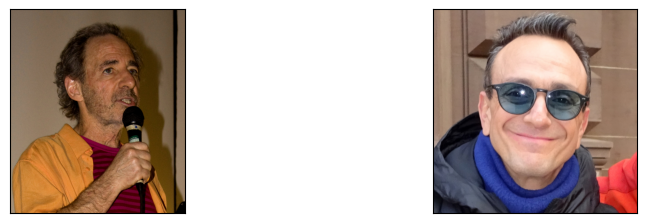

In [12]:
# print(retrieval_results)
from llama_index.schema import ImageNode
from llama_index.response.notebook_utils import (
    display_source_node,
    display_image_uris,
)


image_results = []
MAX_RES = 5
cnt = 0
for r in retrieval_results:
    if isinstance(r.node, ImageNode):
        image_results.append(r.node.metadata["file_path"])
    else:
        if cnt < MAX_RES:
            display_source_node(r)
        cnt += 1

display_image_uris(image_results, [3, 3], top_k=2)